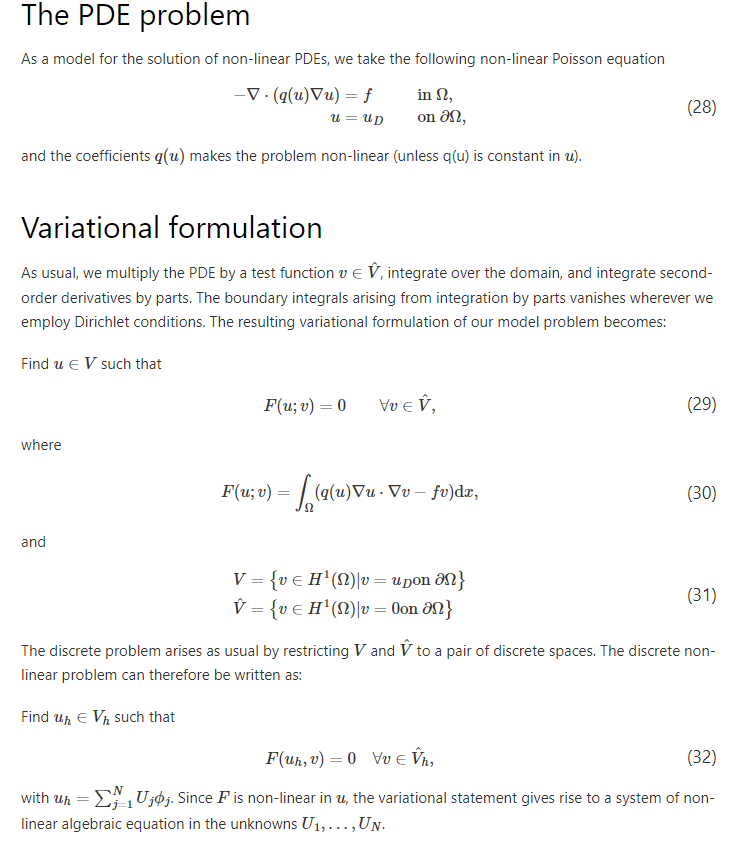


## Test Problem
We choose RHS f and coefficient q(u) and boundary u_D. 

In [1]:
import ufl 
import numpy as np
from mpi4py import MPI
from petsc4py import PETSc
from dolfinx import mesh, fem, io, nls, log

def q(u):
    return 1 + u ** 2

domain = mesh.create_unit_square(MPI.COMM_WORLD, 10, 10)
x = ufl.SpatialCoordinate(domain)
u_ufl = 1 + x[0] + 2 * x[1]
f = - ufl.div(q(u_ufl) *  ufl.grad(u_ufl))

V = fem.FunctionSpace(domain, ("CG", 1))
u_exact = lambda x: eval(str(u_ufl))
uD = fem.Function(V)
uD.interpolate(u_exact)
fdim = domain.topology.dim - 1
bound_facet = mesh.locate_entities_boundary(domain, fdim, lambda x: np.full(x.shape[1], True, dtype=bool))
BC = fem.dirichletbc(uD, fem.locate_dofs_topological(V, fdim, bound_facet))

uh = fem.Function(V)   # problem is non-linear so replace trialfunc with function, which is our unknown
v = ufl.TestFunction(V)
F = q(uh) * ufl.dot(ufl.grad(uh), ufl.grad(v)) * ufl.dx - f * v * ufl.dx

# We define the non-linear problem, and use Newton's Method
# requires methods for evaluating the residual F (including application of boundary conditions),
# as well as a method for computing the Jacobian matrix

NLprob = fem.NonlinearProblem(F, uh, bcs=[BC])

genie = nls.NewtonSolver(MPI.COMM_WORLD, NLprob)
genie.convergence_criterio = "incremental"
genie.rtol = 1e-6  # relative tolerance
genie.report = True

ksp = genie.krylov_solver
opts = PETSc.Options()
option_prefix = ksp.getOptionsPrefix()
opts[f"{option_prefix}ksptype"] = "cg"
opts[f"{option_prefix}pc_type"] = "gamg"
opts[f"{option_prefix}pc_factor_mat_solver_type"] = "mumps"
ksp.setFromOptions()

log.set_log_level(log.LogLevel.INFO)
N, converged = genie.solve(uh)
assert(converged)
print(f"No. of Iterations : {N:d}")
print("new changes")



No. of Iterations : 13
new changes
